In [ ]:
!pip install konlpy

In [ ]:
# 패키지 준비
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib
import urllib.request
from konlpy.tag import Okt # okt(정규화), mocab(빠른속도). komoran, kkma(적용잘됨)
from tqdm import tqdm # 현재 로딩 현황 시각적으로 표현
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# 모든 결과물 한꺼번에 보이기
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity= "all"

In [ ]:
from google.colab import files
uploaded = files.upload()

# 데이터 로딩
import pandas as pd
dataset = pd.read_csv("NaverMovie_train_review_2021-12-09-16-12-57.csv")
dataset.info()

Saving NaverMovie_train_review_2021-12-09-16-12-57.csv to NaverMovie_train_review_2021-12-09-16-12-57.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       10000 non-null  int64 
 1   Reviewer Rating  10000 non-null  int64 
 2   Review           9474 non-null   object
dtypes: int64(2), object(1)
memory usage: 234.5+ KB


## 전처리

In [ ]:
dataset.drop(['Unnamed: 0'],axis=1,inplace=True) # inplace = True : 해당 결과를 저장함을 의미(완전히 고정되기 때문에 사용시 주의)

In [ ]:
dataset.columns
dataset[:5]

Index(['Reviewer Rating', 'Review'], dtype='object')

,Reviewer Rating,Review
0,3,배우 밖에 안 남은 흔한 킬러 영화
1,2,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워...
2,9,가족 내 차별받았던 입장에서 눈물났던 영화입니다
3,10,사랑한다 몬스타엑스!!
4,10,하.. 진짜 충격적인데 솔찌키 잘만들엇어… 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어...


In [ ]:
Rating = dataset.iloc[:,0] # 리뷰 평점만 불러오기

In [ ]:
Label = []
for i in Rating:
  if i > 7:
    Label.append(1) # 긍정 = 1
  else:
    Label.append(0) # 부정 = 0

In [ ]:
dataset['Label'] = Label
dataset[:10]

,Reviewer Rating,Review,Label
0,3,배우 밖에 안 남은 흔한 킬러 영화,0
1,2,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워...,0
2,9,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1
3,10,사랑한다 몬스타엑스!!,1
4,10,하.. 진짜 충격적인데 솔찌키 잘만들엇어… 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어...,1
5,10,NaN,1
6,10,아름다운 고전영화. 오랜만에 서정적인 영화를 보았네,1
7,9,기나긴 대장정의 기분 좋은 출발. 다음 시즌이 기대 된다.다만 악역의 매력이 부족한...,1
8,10,"영상미, 연출, ost 삼박자가 다소 빈약한 스토리 전개를 무마시키고도 남네요. 최...",1
9,2,재미없음 별로 최악이다,0


In [ ]:
dataset.drop(['Reviewer Rating'],axis=1,inplace=True)
dataset[:10]

,Review,Label
0,배우 밖에 안 남은 흔한 킬러 영화,0
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워...,0
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1
3,사랑한다 몬스타엑스!!,1
4,하.. 진짜 충격적인데 솔찌키 잘만들엇어… 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어...,1
5,NaN,1
6,아름다운 고전영화. 오랜만에 서정적인 영화를 보았네,1
7,기나긴 대장정의 기분 좋은 출발. 다음 시즌이 기대 된다.다만 악역의 매력이 부족한...,1
8,"영상미, 연출, ost 삼박자가 다소 빈약한 스토리 전개를 무마시키고도 남네요. 최...",1
9,재미없음 별로 최악이다,0


In [ ]:
# 데이터 중복 확인하기
dataset['Review'].nunique(),dataset['Label'].nunique()

(9385, 2)

In [ ]:
# drop_duplicates() = 중복제거함수
# document 열에서 중복인 내용이 있다면 중복 제거
dataset.drop_duplicates(subset=['Review'], inplace=True) # inplace = True 결과 고정(돌이킬 수 없기에 신중 요망)
print('총 샘플의 수 :',len(dataset)) # 전체 샘플 수 확인

총 샘플의 수 : 9386


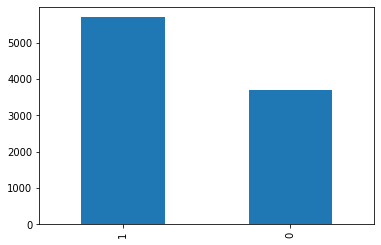

In [ ]:
# label(결과=긍정/부정) 값의 분포 확인
dataset['Label'].value_counts().plot(kind = 'bar')

In [ ]:
# 각각의 label 개수 확인
print(dataset.groupby('Label').size().reset_index(name = 'count'))

   Label  count
0      0   3687
1      1   5699


In [ ]:
# 리뷰 중 null 값 확인
print(dataset.isnull().values.any())
# True면 null 값이 있음을 알 수 있다

True


In [ ]:
dataset = dataset.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(dataset.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [ ]:
# Null 값을 가진 샘플이 어느 인덱스 위치에 존재하는지 출력
dataset.loc[dataset.Review.isnull()]
# 존재하지 않기 때문에 출력되지 않음

,Review,Label


In [ ]:
dataset['Review'] = dataset['Review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
dataset['Review'] = dataset['Review'].str.replace('^ +', "") # 공백은 empty 값으로 변경
dataset['Review'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
dataset = dataset.dropna(how='any') # Null 값 제거
print('전처리 후 총 샘플의 개수 :',len(dataset))

전처리 후 총 샘플의 개수 : 9347


## 토큰화

In [ ]:
# 불용어 정의: 분석가가 정하기 나름
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [ ]:
dataset.columns

Index(['Review', 'Label'], dtype='object')

In [ ]:
review_list = dataset.iloc[:,0]

In [ ]:
okt = Okt()
# 형태소 분석: 토큰화를 하면서 불용어를 제거하여 x_train에 저장
x_train = []
for sentence in tqdm(review_list):
    tokenized_sentence = okt.morphs(sentence, stem=True)
    stopwords_removed_sentence =  [word for word in tokenized_sentence if not word in stopwords]
    dataset.append(stopwords_removed_sentence)

In [ ]:
print(review_list[:3])

0                          배우 밖에 안 남은 흔한 킬러 영화
1    나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워
2                   가족 내 차별받았던 입장에서 눈물났던 영화입니다
Name: Review, dtype: object


In [ ]:
dataset['Review Token'] = review_list

In [ ]:
dataset.head()

,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,배우 밖에 안 남은 흔한 킬러 영화
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,가족 내 차별받았던 입장에서 눈물났던 영화입니다
3,사랑한다 몬스타엑스,1,사랑한다 몬스타엑스
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...


#### 정수 인코딩

In [ ]:
# 단어 집합 생성
tokenizer = Tokenizer()
tokenizer.fit_on_texts(review_list)
print(tokenizer.word_index)
# 단어의 빈도를 기준으로 정수값 할당. 1~

{'영화': 1, '너무': 2, '진짜': 3, '잘': 4, '수': 5, '정말': 6, '더': 7, '다': 8, '이': 9, '연기': 10, '그냥': 11, '그': 12, '보고': 13, '것': 14, '영화를': 15, '좀': 16, '재밌게': 17, '왜': 18, '봤는데': 19, '있는': 20, '이런': 21, '스토리': 22, '보는': 23, '본': 24, '영화는': 25, '연기가': 26, '영화가': 27, '좋은': 28, '많이': 29, '다시': 30, '그리고': 31, '봤습니다': 32, '꼭': 33, '한': 34, '없는': 35, '또': 36, '하는': 37, '스토리가': 38, '넘': 39, '봤어요': 40, '볼': 41, '내': 42, '역시': 43, '이렇게': 44, '안': 45, '배우들': 46, '마지막': 47, '시간': 48, '오랜만에': 49, '연출': 50, '좋았어요': 51, '연기도': 52, '배우들의': 53, '다른': 54, '모두': 55, '좋고': 56, '없고': 57, '같은': 58, '최고의': 59, '재미있게': 60, '대한': 61, '내내': 62, '연기는': 63, '평점': 64, '보면': 65, '와': 66, '이게': 67, '하지만': 68, 'ㅠㅠ': 69, 'ㅋㅋ': 70, '느낌': 71, '좋았다': 72, '조금': 73, '참': 74, '보기': 75, '큰': 76, '배우': 77, '계속': 78, '할': 79, '없이': 80, '영화입니다': 81, '생각보다': 82, '작품': 83, '끝까지': 84, '그래도': 85, '봐도': 86, '내가': 87, '없다': 88, '좋았습니다': 89, '스토리도': 90, '아주': 91, '최고': 92, '점': 93, '하고': 94, '스토리는': 95, '특히': 96, '모든': 97, '근데': 98, '만든': 9

In [ ]:
# 토큰화를 하고 나면 <- 빈도수를 기준으로 정수가 할당되어 있음. <- 할당된 토큰 값이 높다는 말은? <- 등장 빈도수가 적다.
# 너무 적게 표현된 단어들은 제거한다
threshold = 3 # 등장 빈도수가 3회 미만인 단어들의 분포 확인
total_cnt = len(tokenizer.word_index) # 총 토큰(단어) 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
rare_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
total_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총합

# 단어와 빈도수의 쌍(pair)를 key와 value로 받는다
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if (value < threshold ) : 
        rare_cnt = rare_cnt+1
        rare_freq  = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 41282
등장 빈도가 2번 이하인 희귀 단어의 수: 35701
단어 집합에서 희귀 단어의 비율: 86.48079065936727
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 37.32795799737483


In [ ]:
# 전체 단어 개수 중 빈도수 2 이하인 단어는 제거.
# 0 번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 5582


In [ ]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(review_list)
review_list = tokenizer.texts_to_sequences(review_list)

In [ ]:
print(review_list[:3])

[[77, 287, 45, 1200, 1982, 1], [153, 821, 44, 1507, 1339, 508, 508, 3853], [620, 42, 1705, 81]]


In [ ]:
dataset['Review Token'] = review_list
dataset.head()

,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"


In [ ]:
for i in range(0,len(dataset)):
  if len(review_list[i]) == 0:
    dataset.drop(dataset.index[i])
  else:
    pass

dataset.head()

,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"
...,...,...,...
9995,초반만 재미있게 흐르다가 점점 엉성하게 진행된다,0,"[3512, 60, 622]"
9996,진짜 재밋게봤음 음악스토리영상다좋음,1,[3]
9997,장인 정신으로 빚어낸 장면 하나하나는 놀라움 그 자체 시대를 풍미하는 배우들을 한 ...,1,"[3900, 475, 12, 827, 786, 980, 34, 41, 5, 20, ..."
9998,주인공의 연기는 물론 목소리와 음악이 너무 좋았습니다 라라랜드와 위대한쇼맨이 섞인 ...,1,"[736, 63, 586, 3873, 395, 2, 89, 3844, 1017, 1..."


,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"


In [ ]:
len(dataset)
dataset.head()

9347

,Review,Label,Review Token
0,배우 밖에 안 남은 흔한 킬러 영화,0,"[77, 287, 45, 1200, 1982, 1]"
1,나는 모르겠고 이렇게 카메라 흔들리는 영상은 못보겠음 ㅜ ㅜ 아우 어지러워,0,"[153, 821, 44, 1507, 1339, 508, 508, 3853]"
2,가족 내 차별받았던 입장에서 눈물났던 영화입니다,1,"[620, 42, 1705, 81]"
3,사랑한다 몬스타엑스,1,"[1508, 1340]"
4,하 진짜 충격적인데 솔찌키 잘만들엇어 앞부분 눈뜨고 보기 힘듬 근데 잘만들엇어 연기...,1,"[296, 3, 75, 98, 189, 3854]"


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(dataset['Review Token'],dataset['Label'],random_state=0)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(7010,)
(2337,)
(7010,)
(2337,)


리뷰의 최대 길이 : 181
리뷰의 평균 길이 : 7.19358059914408


(array([2.505e+03, 2.390e+03, 7.810e+02, 5.600e+02, 2.910e+02, 1.460e+02,
        1.140e+02, 6.800e+01, 4.500e+01, 2.100e+01, 1.500e+01, 1.400e+01,
        1.300e+01, 1.000e+01, 6.000e+00, 3.000e+00, 5.000e+00, 2.000e+00,
        3.000e+00, 3.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 2.000e+00,
        0.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  0.  ,   3.62,   7.24,  10.86,  14.48,  18.1 ,  21.72,  25.34,
         28.96,  32.58,  36.2 ,  39.82,  43.44,  47.06,  50.68,  54.3 ,
         57.92,  61.54,  65.16,  68.78,  72.4 ,  76.02,  79.64,  83.26,
         86.88,  90.5 ,  94.12,  97.74, 101.36, 104.98, 108.6 , 112.22,
        115.84, 119.46, 123.08, 126.7 , 130.32, 133.94, 137.56, 141.18,
        144.8 , 

Text(0.5, 0, 'length of samples')

Text(0, 0.5, 'number of samples')

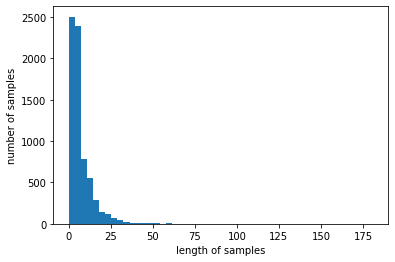

In [ ]:
print('리뷰의 최대 길이 :',max(len(l) for l in x_train))
print('리뷰의 평균 길이 :',sum(map(len, x_train))/len(x_train))
plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

max_len = 25
below_threshold_len(max_len, x_train)

전체 샘플 중 길이가 25 이하인 샘플의 비율: 96.8188302425107


In [ ]:
x_train = pad_sequences(x_train, maxlen = max_len)
x_test = pad_sequences(x_test, maxlen = max_len)

## LSTM 모델링

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model2.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
87/88 [============================>.] - ETA: 0s - loss: 0.6460 - acc: 0.6259
Epoch 00001: val_acc improved from -inf to 0.70613, saving model to best_model2.h5
88/88 [==============================] - 11s 78ms/step - loss: 0.6452 - acc: 0.6273 - val_loss: 0.5737 - val_acc: 0.7061
Epoch 2/15
87/88 [============================>.] - ETA: 0s - loss: 0.4778 - acc: 0.7784
Epoch 00002: val_acc improved from 0.70613 to 0.73752, saving model to best_model2.h5
88/88 [==============================] - 6s 72ms/step - loss: 0.4766 - acc: 0.7791 - val_loss: 0.5639 - val_acc: 0.7375
Epoch 3/15
87/88 [============================>.] - ETA: 0s - loss: 0.3831 - acc: 0.8251
Epoch 00003: val_acc did not improve from 0.73752
88/88 [==============================] - 6s 72ms/step - loss: 0.3825 - acc: 0.8252 - val_loss: 0.5519 - val_acc: 0.7361
Epoch 4/15
87/88 [============================>.] - ETA: 0s - loss: 0.3276 - acc: 0.8513
Epoch 00004: val_acc did not improve from 0.73752
88/88 [=======

In [ ]:
# %cd 함수를 이용해서 모델이 저장된 디렉토리로 이동
%cd /content/
!pwd
!ls
model.save('best_model2.h5')

/content
/content
best_model2.h5	NaverMovie_train_review_2021-12-09-16-12-57.csv
best_model.h5	sample_data


In [ ]:
loaded_model = load_model('best_model2.h5')
print("\n 테스트 정확도: %.4f" %(loaded_model.evaluate(x_test,y_test)[1]))

74/74 [==============================] - 1s 11ms/step - loss: 0.8206 - acc: 0.7026

 테스트 정확도: 0.7026


In [ ]:
# 학습셋의 손실
y_loss = history.history['loss']
# 테스트 셋의 손실
y_vloss = history.history['val_loss']

Text(0.5, 0, 'epoch')

Text(0, 0.5, 'loss')

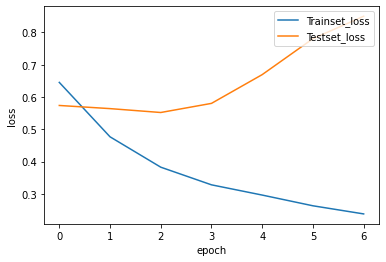

In [ ]:
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_loss, label='Trainset_loss')
plt.plot(x_len, y_vloss, label='Testset_loss')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

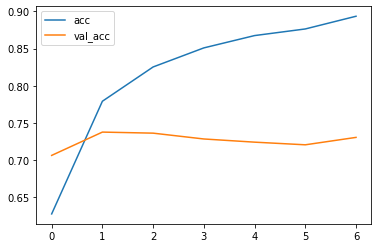

In [ ]:
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()

In [ ]:
#새로운 문장 예측해주는 함수
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 '긍정' 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 '부정' 리뷰입니다.\n".format((1 - score) * 100))

In [ ]:
sentiment_predict('이게 영화인가')

51.04% 확률로 '긍정' 리뷰입니다.



In [ ]:
sentiment_predict('이딴게 영화라고')

99.64% 확률로 '부정' 리뷰입니다.



In [ ]:
sentiment_predict('배고프다')

51.00% 확률로 '긍정' 리뷰입니다.



In [ ]:
sentiment_predict('재밌다')

90.22% 확률로 '긍정' 리뷰입니다.



## 영화리뷰 예측

In [ ]:
!pwd
!ls

/content
best_model2.h5	NaverMovie_train_review_2021-12-09-16-12-57.csv
best_model.h5	sample_data


In [ ]:
# 저장된 모델을 불러오기 위해 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
!ls
#모델 불러오기
loaded_model = load_model('/content/best_model2.h5')

best_model2.h5	gdrive						 sample_data
best_model.h5	NaverMovie_train_review_2021-12-09-16-12-57.csv


In [ ]:
# File Upload
from google.colab import files
drive.mount('/content/gsample_data')
df = pd.read_csv('/content/sample_data/NaverMovie_Cats_2021-12-08-10-37-20.csv')
df.info()
df [5:]

Mounted at /content/gsample_data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5518 entries, 0 to 5517
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Review Number    5518 non-null   int64 
 1   Reviewer         5518 non-null   object
 2   Date             5518 non-null   object
 3   Reviewer Rating  5518 non-null   int64 
 4   Review           5279 non-null   object
 5   Like             5518 non-null   int64 
 6   Dislike          5518 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 301.9+ KB


,Review Number,Reviewer,Date,Reviewer Rating,Review,Like,Dislike
5,6,Uk(arym****),2019.12.24 22:20,1,인생영화 입니다 진짜 후유증이 가시질않내요 이렇게 우와를 많이 해본적이 없어요 제가...,1285,284
6,7,무뚜기(ssol****),2019.12.25 01:11,1,정말 내인생에 최악의 영화~~5분만에 잠들었음~~,865,113
7,8,정구철(phot****),2019.12.25 02:23,2,캣츠는 뮤지컬로만 보는걸로 합시다,750,77
8,9,홀짝(love****),2019.12.24 15:33,1,불쾌한 골짜기 현상 그 자체. 바퀴벌레 씬과 고양이들이 바퀴벌레를 먹는 씬은 충격과...,758,150
9,10,jae(jaen****),2019.12.24 14:32,1,한마디로 정리한다. 냥복동임 끝.,795,207
...,...,...,...,...,...,...,...
5513,5514,익명(k_so****),2019.12.25 14:16,10,진.짜 대박 꼭 봐주세요 고양이가 정말 사랑스러워지는 영화??,1,28
5514,5515,yksu****,2020.01.26 14:37,10,화려하고 멋진 뮤지컬영화,6,34
5515,5516,pontina(chdp****),2020.01.28 18:50,10,뮤지컬 좋아해서 많이 보러 다니는데 영화도 너무 즐거웠어요^^,6,35
5516,5517,경만(hiro****),2020.02.05 18:56,10,"배우들의 노래와 아름다운 춤 덕분에 뮤지컬 캣츠가 좀더 친근하게 다가왔고, 오랜만에...",5,51


In [ ]:
df.drop(['Reviewer', 'Date','Like', 'Dislike'],axis=1,inplace=True)
df['Review'].nunique()
df.drop_duplicates(subset=['Review'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
df.loc[df.Review.isnull()]
df = df.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(len(df))

5175

,Review Number,Reviewer Rating,Review
150,151,2,NaN


5175


In [ ]:
review_list = df.iloc[:,2]

In [ ]:
# 새로운 문장 예측해주는 함수
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    cat_list.append("긍정")
  else:
    cat_list.append("부정")

cat_list=[]
for i in review_list:
  sentiment_predict("%s" %i)

df['Result'] = cat_list
df[:5]

,Review Number,Reviewer Rating,Review,Result
0,1,1,덕분에 크리스마스에 헤어질뻔 했네요^^,부정
1,2,2,영화가 끝나도 자리를 뜨지 못하시는 분이 계셨다. 주무시고 계셨다...,부정
2,3,1,내가 영화관에서 잤는데 꿈 내용이 더 재밌음,긍정
3,4,2,역대급핵노잼 절대보지마요 돈아까워여 알바댓글때문이 낚여서 봣네여 흑흑내돈,부정
4,5,4,등장인물 소개하다가 메모리즈 3번 부르고 끝,부정


In [ ]:
rating_list = df.iloc[:,1]
rating_result = []
for i in rating_list:
  if i > 7:
    rating_result.append("긍정")
  else:
    rating_result.append("부정")
df['Rating Result'] = rating_result
df.head()

,Review Number,Reviewer Rating,Review,Result,Rating Result,Label
0,1,1,덕분에 크리스마스에 헤어질뻔 했네요^^,부정,부정,0
1,2,2,영화가 끝나도 자리를 뜨지 못하시는 분이 계셨다. 주무시고 계셨다...,부정,부정,0
2,3,1,내가 영화관에서 잤는데 꿈 내용이 더 재밌음,긍정,부정,1
3,4,2,역대급핵노잼 절대보지마요 돈아까워여 알바댓글때문이 낚여서 봣네여 흑흑내돈,부정,부정,0
4,5,4,등장인물 소개하다가 메모리즈 3번 부르고 끝,부정,부정,0


In [ ]:
how_same = []
for x in range(0,len(df)):
  if cat_list[x] == rating_result[x]:
    how_same.append(0) # 같음을 의미
  else:
    how_same.append(1) # 일치하지 않음을 의미
df['Label'] = how_same
df.head()

,Review Number,Reviewer Rating,Review,Result,Rating Result,Label
0,1,1,덕분에 크리스마스에 헤어질뻔 했네요^^,부정,부정,0
1,2,2,영화가 끝나도 자리를 뜨지 못하시는 분이 계셨다. 주무시고 계셨다...,부정,부정,0
2,3,1,내가 영화관에서 잤는데 꿈 내용이 더 재밌음,긍정,부정,1
3,4,2,역대급핵노잼 절대보지마요 돈아까워여 알바댓글때문이 낚여서 봣네여 흑흑내돈,부정,부정,0
4,5,4,등장인물 소개하다가 메모리즈 3번 부르고 끝,부정,부정,0


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44557 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48512 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44557 missing from current font.
  font.set_text

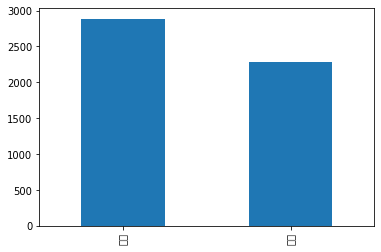

In [ ]:
df['Result'].value_counts().plot(kind = 'bar')

In [ ]:
print(df.groupby('Result').size().reset_index(name = 'count'))

  Result  count
0     긍정   2289
1     부정   2886


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44557 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48512 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44557 missing from current font.
  font.set_text

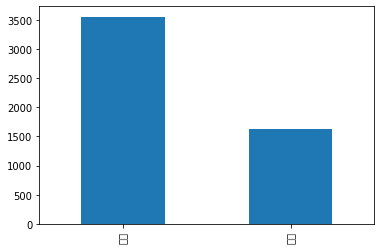

In [ ]:
df['Rating Result'].value_counts().plot(kind = 'bar')

In [ ]:
print(df.groupby('Rating Result').size().reset_index(name = 'count'))

  Rating Result  count
0            긍정   1621
1            부정   3554


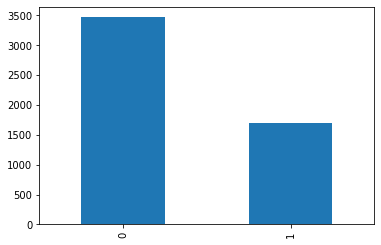

In [ ]:
df['Label'].value_counts().plot(kind = 'bar')

In [ ]:
print(df.groupby('Label').size().reset_index(name = 'count'))

   Label  count
0      0   3469
1      1   1706


In [ ]:
# Cats를 분석한 결과 정확도를 측정한다
num = (3469/len(df))*100
num = round(num,2)
print("Cats를 분석한 결과 해당 모델의 일치도는 %s입니다." %num)

Cats를 분석한 결과 해당 모델의 일치도는 67.03입니다.


In [ ]:
df.drop(['Rating Result','Label'],axis=1)
df.to_csv('NaverMovie_Cats_ReviewResult2_2021-12-08-10-37-20.csv',encoding='euc-kr')

,Review Number,Reviewer Rating,Review,Result
0,1,1,덕분에 크리스마스에 헤어질뻔 했네요^^,부정
1,2,2,영화가 끝나도 자리를 뜨지 못하시는 분이 계셨다. 주무시고 계셨다...,부정
2,3,1,내가 영화관에서 잤는데 꿈 내용이 더 재밌음,긍정
3,4,2,역대급핵노잼 절대보지마요 돈아까워여 알바댓글때문이 낚여서 봣네여 흑흑내돈,부정
4,5,4,등장인물 소개하다가 메모리즈 3번 부르고 끝,부정
...,...,...,...,...
5513,5514,10,진.짜 대박 꼭 봐주세요 고양이가 정말 사랑스러워지는 영화??,긍정
5514,5515,10,화려하고 멋진 뮤지컬영화,부정
5515,5516,10,뮤지컬 좋아해서 많이 보러 다니는데 영화도 너무 즐거웠어요^^,긍정
5516,5517,10,"배우들의 노래와 아름다운 춤 덕분에 뮤지컬 캣츠가 좀더 친근하게 다가왔고, 오랜만에...",긍정
